## Script for training ready-for-discharge (RFD) classifiers using multiple source cross-validation. 

#### TODO: implement multiple folds per source when using both MIMIC and GICU.

In [348]:
import pandas as pd
import numpy as np
import bisect
import pickle
import yaml
from pathlib import Path

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, brier_score_loss
from sklearn.metrics import auc as auc_metric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import joblib
%matplotlib inline

In [317]:
original_features = [
    'airway', 'fio2', 'spo2_min', 
    'hco3', 'resp_min', 'resp_max', 
    'bp_min', 'hr_min', 'hr_max', 'pain', 
    'gcs_min', 'temp_min', 'temp_max', 
    'haemoglobin', 'k','na','creatinine','bun'
] 

config = {
    'data_sources': ['mimic', 'gicu'],  # 'gicu' can be included or omitted to train on MIMIC only
    'feature_set': 'extended',  # 'extended' includes demographic features
    'features': {
        'original': original_features,
        'extended': original_features + ['bmi', 'los', 'age', 'sex']
    },
    'fit_score': None,  # optimise hyperparameters according to this score (e.g. 'f1')
    'n_splits': 1,  # number of repeated train:test splits to evaluate for peformance statistics
    'random_seed': 42,
    'missing_data_treatment': 'imputed',  # or 'completecase'
    'data_directory': Path('./fms/'),
    'results_directory': Path('./results'),
    'fpr_range': np.linspace(0.1, 1, 10),  # false positive rates at which to evaluate relevant performance metrics
    'cv_folds': 5,  # number of cross-validation folds to use (currently only used when GICU is omitted)
    'test_size': 0.4  # fraction to hold out for test
}

In [319]:
features = config['features'][config['feature_set']]

with open(config['results_directory'] / 'config.yaml', 'w') as out_file:
    yaml.dump(config, out_file)

In [320]:
def fm_path(data_source, missing_data, feature_set, standardised=False, standard_scaled = True):
    
    file_name = "fm_%s_%s_%s" % (data_source, missing_data, feature_set)
    
    if standardised:
        file_name = file_name + '_standardised'
    elif standard_scaled:
        file_name = file_name + '_standardscale'
    
    return (config['data_directory'] / file_name).with_suffix('.csv')

In [321]:
fm_mimic = pd.read_csv(fm_path('mimic', config['missing_data_treatment'], config['feature_set']))

fm_gicu = (
    pd.read_csv(fm_path('gicu', config['missing_data_treatment'], config['feature_set']))
    if 'gicu' in config['data_sources']
    else None
)

In [323]:
print("MIMIC cohort contains: ", len(fm_mimic), " patients.")
if 'gicu' in config['data_sources']:
    print("GICU cohort contains: ", len(fm_gicu), " patients.")

MIMIC cohort contains:  13243  patients.
GICU cohort contains:  3506  patients.


In [324]:
fm_mimic

,ICUSTAY_ID,cohort,outcome,airway,fio2,spo2_min,hco3,resp_min,resp_max,bp_min,...,temp_max,haemoglobin,k,na,creatinine,bun,bmi,los,age,sex
0,200289,1,0,-0.569427,1.313961,-0.310969,0.063247,-0.703850,-1.170127,2.003506,...,0.748216,-0.300501,0.824259,-0.710476,-0.443744,-0.765125,0.022914,-0.678402,-0.148308,1.088614
1,200325,1,0,-0.569427,0.575756,1.111420,1.112160,0.588508,-0.009624,0.891544,...,0.590078,-0.421960,-0.813367,0.121503,-0.575071,-0.572680,-0.038786,0.666224,-0.350284,1.088614
2,200352,1,0,-0.569427,-0.103393,0.542465,0.902378,0.750053,-0.175410,-0.081422,...,-0.754306,-0.385523,0.278384,-0.918471,1.854473,0.678209,-0.028783,-0.632502,0.033471,1.088614
3,200671,1,0,-0.569427,0.206653,-1.164403,1.321943,2.203955,1.150879,-1.286047,...,0.115523,-0.434106,-0.449450,1.577467,-0.575071,-0.572680,-0.003999,-0.496825,0.033471,1.088614
4,201004,1,0,-0.569427,0.206653,1.111420,-1.405231,0.588508,1.316665,-0.081422,...,0.273803,-0.415887,-1.177284,-1.334461,-0.575071,-0.957569,0.000952,-0.396053,-0.996609,1.088614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13238,298981,1,1,-0.569427,-0.162449,0.542465,0.692595,1.234687,2.311382,-0.266749,...,0.273803,-0.428033,-0.267492,0.329498,-0.575071,-0.909458,-0.050423,-0.260552,-0.269494,-0.918599
13239,299046,1,1,-0.569427,0.575756,-0.026491,0.063247,0.750053,0.985093,-0.313081,...,0.194663,-0.452325,-1.177284,0.537493,-0.575071,-0.957569,0.160158,-0.463451,-0.956214,1.088614
13240,299652,1,1,-0.569427,2.052166,-0.595447,-0.775883,-0.219216,-0.341196,-0.405744,...,1.538904,-0.409814,-0.085533,0.537493,-0.115427,-0.765125,-0.005415,-0.600881,4.638537,1.088614
13241,299764,1,1,-0.569427,-3.115270,-0.310969,1.112160,-0.703850,-0.506983,1.957174,...,1.380766,-0.309611,0.096425,0.745488,-0.246754,-0.717014,0.170799,-0.619221,-0.471470,-0.918599


In [325]:
def split_data(mimic,
                gicu, test_size=config['test_size'],
                seed=config['random_seed'],
                VERBOSE=True):
    
    if gicu is not None:
        # first we split the smaller GICU data according to test_size
        g_train, g_test = train_test_split(fm_gicu, test_size=test_size, random_state=seed)

        # then split MIMIC such that size of m_test equals that of g_test
        mfrac = len(g_test) / len(fm_mimic)
        
    else:
        g_train = None
        g_test = None
        mfrac = test_size
        
    m_train, m_test = train_test_split(fm_mimic, test_size=mfrac, random_state=seed)
    
    if VERBOSE:
        print("Using %.4f of MIMIC as training data" %(1-mfrac))
        print("giving test sets gicu_test:%d and mimic_test: %d" %(len(g_test) if g_test is not None else 0,len(m_test)))


    return m_train, m_test, g_train, g_test

In [326]:
_,_,_,_ = split_data(fm_mimic, fm_gicu)

Using 0.8941 of MIMIC as training data
giving test sets gicu_test:1403 and mimic_test: 1403


In [327]:
def get_fpr_tpr_for_threshold(fpr, tpr, threshold, prob_thresholds):
    p = bisect.bisect_left(fpr, threshold)
    fpr = fpr.copy()
    fpr[p] = threshold
    return fpr[: p + 1], tpr[: p + 1], prob_thresholds[: p + 1]

def partial_auc_score(y, y_pred, threshold=0.5):
    fpr, tpr, prob_thresholds = roc_curve(y, y_pred, pos_label=1) 
    fpr_t, tpr_t, _ = get_fpr_tpr_for_threshold(fpr, tpr, threshold, prob_thresholds)
    
    return auc_metric(fpr_t,tpr_t) 

def calculate_all_metrics(ytrue, ypred, fpr_thresh):
    
    results = {}
    fpr, tpr, prob_thresholds = roc_curve(ytrue, ypred, pos_label=1) 
    fpr_t, tpr_t, cutoff = get_fpr_tpr_for_threshold(fpr, tpr, fpr_thresh, prob_thresholds)
    
    ypred_class = ypred>=cutoff[-1]
    
    results['f1'] = f1_score(ytrue, ypred_class)
    results['accuracy'] = accuracy_score(ytrue, ypred_class)
    results['sensitivity'] = tpr_t[-1]
    results['specificity'] = 1 - fpr_t[-1]
    results['pauc'] = partial_auc_score(ytrue, ypred, threshold=fpr_thresh)
    
    return results

In [328]:
def store_performance_results(ytrue, ypred, results_dict, sps, dbsource=None):
    
    auc = roc_auc_score(ytrue, ypred)
    brier = brier_score_loss(ytrue, ypred)
    
    results_dict['performance_%s' %dbsource]['auc'].append(auc)
    results_dict['performance_%s' %dbsource]['brier'].append(brier)
    
    for ff in config['fpr_range']:
        
        results = calculate_all_metrics(ytrue, ypred, ff)
        for metric, result in results.items():
            results_dict['performance_%s' %dbsource][metric]['%.2f' %ff].append(result)
    
    return results_dict

In [330]:
def optimise_return_test_scores(
    parameters_to_optimise, classifier, 
    fm_mimic, fm_gicu, config, 
    verbose=False, savename=None
):
    
    fpr_range = config['fpr_range'] 
    number_of_splits=config['n_splits']
    features = config['features'][config['feature_set']]
    use_gicu = 'gicu' in config['data_sources']
    
    # initialise results dictionary
    results_dict = dict()
    for dbs in ['gicu', 'mimic', 'train', 'combined']:
        
        results_dict['performance_%s' %dbs] = {
            'auc': [],
            'brier': []
        }
    
        # the following metrics are evaulated at a range of FPR values:
        performance_metrics = ['f1', 'accuracy', 'sensitivity', 'specificity', 'pauc']
        for metric in performance_metrics:
            results_dict['performance_%s' %dbs][metric] = {
                '%.2f' %ff: []
                for ff in fpr_range
            }

    params = []
    this_seed = []
    opt_clfs = []
    
    for sp in range(number_of_splits):
        
        print("Split %d" %sp)
        m_train, m_test, g_train, g_test = split_data(fm_mimic, fm_gicu, seed=sp)
        
        train = m_train.append(g_train)
        combined = m_test.append(g_test)
        
        if use_gicu:
            test_fold = [0 for i in m_train]  # 0th test fold is MIMC data
            test_fold.extend([1 for i in g_train])  # 1st test fold is GICU data
            cv_folds = PredefinedSplit(test_fold)
        else:
            cv_folds = config['cv_folds']
    
        print("Creating gridsearch.")
        clf = GridSearchCV(
            classifier, parameters_to_optimise, cv=cv_folds, 
            scoring=config['fit_score'], return_train_score=False, refit=True, verbose=True, n_jobs=-1
        )
        
        print("Running gridsearch...")
        clf.fit(train[features].to_numpy(), list(train['outcome']))
        best_params = clf.best_params_
        print("Gridsearch complete.")
        
        # evaluate performance metrics on test sets, training set and combined test sets:
        test_frames = (
            {'gicu': g_test, 'mimic': m_test, 'train': train, 'combined': combined}
            if use_gicu
            else {'mimic': m_test, 'train': train}
        )
        for dbs in test_frames.keys():
            
            ytrue = list(test_frames[dbs]['outcome'])
            ypred = clf.predict_proba(test_frames[dbs][features].to_numpy())[:,1]
            results_dict = store_performance_results(ytrue, ypred, results_dict, sp, dbsource=dbs)

        params.append(best_params)    
        this_seed.append(sp)
        opt_clfs.append(clf)
        
        if sp%20==0:
            with open(savename, 'wb') as fh:
                pickle.dump(results_dict, fh)
    
    ## add additional information to results dictionary
    results_dict['optimal_classifiers'] = opt_clfs
    results_dict['split_seeds'] = this_seed
    results_dict['optimal_params'] = params
    
    with open(savename, 'wb') as fh:
            pickle.dump(results_dict, fh)
        
    return results_dict

#### LR classifier:

In [331]:
hyper_parameters = [{'C': np.logspace(-3,3,20)}]

classifier = linear_model.LogisticRegression(
    penalty='l1', random_state=config['random_seed'], 
    fit_intercept='True', solver='liblinear'
)

results_fname = config['results_directory'] / 'lr_results_raw_combined.pickle'

In [332]:
lr_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, config, verbose=False, savename=results_fname
)

Split 0
Using 0.8941 of MIMIC as training data
giving test sets gicu_test:1403 and mimic_test: 1403
Creating gridsearch.
Running gridsearch...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


Gridsearch complete.


In [333]:
metric = 'auc'

print("Mimic %.4f (+- %.4f)" %(np.mean(lr_results['performance_mimic'][metric]),np.std(lr_results['performance_mimic'][metric])))
print("GICU %.4f (+- %.4f)" %(np.mean(lr_results['performance_gicu'][metric]),np.std(lr_results['performance_gicu'][metric])) )
print("Combined %.4f (+- %.4f)" %(np.mean(lr_results['performance_combined'][metric]),np.std(lr_results['performance_combined'][metric])) )
print("Training %.4f (+- %.4f)" %(np.mean(lr_results['performance_train'][metric]),np.std(lr_results['performance_train'][metric])) )


Mimic 0.8890 (+- 0.0000)
GICU 0.8718 (+- 0.0000)
Combined 0.8773 (+- 0.0000)
Training 0.8725 (+- 0.0000)


#### Random Forest:

In [334]:
hyper_parameters = [{'n_estimators': [20,50,100],'max_features': [0.3,0.5,0.7], 'max_depth':[4,5,6,7]}]
classifier = RandomForestClassifier(random_state=config['random_seed'], n_jobs=-1)
results_fname = config['results_directory'] / 'rf_results_raw_combined.pickle'

In [335]:
rf_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, 
    config, verbose=False, savename=results_fname
)                        

Split 0
Using 0.8941 of MIMIC as training data
giving test sets gicu_test:1403 and mimic_test: 1403
Creating gridsearch.
Running gridsearch...
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Gridsearch complete.


In [363]:
# auc, brier

metric = 'auc'
print("MIMIC %.4f (+- %.4f)" %(np.mean(rf_results['performance_mimic'][metric]),np.std(rf_results['performance_mimic'][metric])))
print("GICU %.4f (+- %.4f)" %(np.mean(rf_results['performance_gicu'][metric]),np.std(rf_results['performance_gicu'][metric])) )
print("Combined %.4f (+- %.4f)" %(np.mean(rf_results['performance_combined'][metric]),np.std(rf_results['performance_combined'][metric])) )
print("Training %.4f (+- %.4f)" %(np.mean(rf_results['performance_train'][metric]),np.std(rf_results['performance_train'][metric])) )


# then max across the range for the others
performance_metrics = ['f1', 'accuracy', 'sensitivity', 'specificity', 'pauc']

for metric in performance_metrics:
    print(metric, (max(rf_results['performance_combined'][metric].values())))


rf_results['performance_combined']

MIMIC 0.8944 (+- 0.0000)
GICU 0.8678 (+- 0.0000)
Combined 0.8818 (+- 0.0000)
Training 0.8885 (+- 0.0000)
f1 [0.8293299620733249]
accuracy [0.8075552387740556]
sensitivity [1.0]
specificity [0.9]
pauc [0.8818418565300443]


{'auc': [0.8818418565300443],
 'brier': [0.14206911509915088],
 'f1': {'0.10': [0.7006578947368423],
  '0.20': [0.8025122121423588],
  '0.30': [0.8293299620733249],
  '0.40': [0.8187203791469194],
  '0.50': [0.7975113122171946],
  '0.60': [0.7729861676159479],
  '0.70': [0.7483064095883272],
  '0.80': [0.7240251572327044],
  '0.90': [0.7009958707796939],
  '1.00': [0.6792186396799247]},
 'accuracy': {'0.10': [0.7405559515324305],
  '0.20': [0.7982893799002139],
  '0.30': [0.8075552387740556],
  '0.40': [0.781895937277263],
  '0.50': [0.744832501781896],
  '0.60': [0.7017106200997861],
  '0.70': [0.6557377049180327],
  '0.80': [0.6090520313613685],
  '0.90': [0.5612972202423379],
  '1.00': [0.5142551674982181]},
 'sensitivity': {'0.10': [0.5904365904365905],
  '0.20': [0.796950796950797],
  '0.30': [0.9092169092169092],
  '0.40': [0.9577269577269577],
  '0.50': [0.9771309771309772],
  '0.60': [0.9875259875259875],
  '0.70': [0.9951489951489951],
  '0.80': [0.9972279972279973],
  '0.90':

#### Now we save one of each trained classifier along with the train and test data for that split:

In [339]:
rf = rf_results['optimal_classifiers'][0]
lr = lr_results['optimal_classifiers'][0]

In [340]:
seed = rf_results['split_seeds'][0]
lr_seed = lr_results['split_seeds'][0]
assert lr_seed == seed

In [341]:
m_train, m_test, g_train, g_test = split_data(fm_mimic, fm_gicu, seed=seed)

Using 0.8941 of MIMIC as training data
giving test sets gicu_test:1403 and mimic_test: 1403


In [343]:
with open(config['results_directory'] / 'rf_combined_standardscale.pickle', 'wb') as out_file:
    pickle.dump(rf, out_file)
    
with open(config['results_directory'] / 'lr_combined_standardscale.pickle', 'wb') as out_file:
    pickle.dump(lr, out_file)

In [344]:
m_train.to_csv(config['results_directory'] / 'm_training_data_standardscale.csv')
m_test.to_csv(config['results_directory'] / 'm_test_data_standardscale.csv')

train_combined = m_train.append(g_train)
test_combined = m_test.append(g_test)

train_combined.to_csv(config['results_directory'] / 'combined_training_data_standardscale.csv')
test_combined.to_csv(config['results_directory'] / 'combined_test_data_standardscale.csv')

#### Quick sanity check of classifier performance:

In [345]:
def roc(df, clf):
    ytrue = df['outcome']
    ypred = clf.predict_proba(df[features].to_numpy())[:,1]
    fpr, tpr, _ = roc_curve(ytrue, ypred)
    auc = auc_metric(fpr, tpr)
    return fpr, tpr, auc

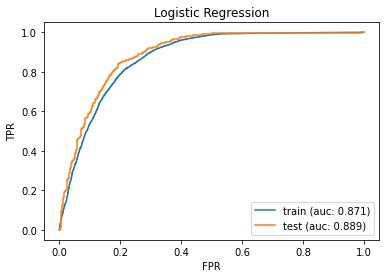

In [346]:
fpr_train, tpr_train, auc_train = roc(m_train, lr)
fpr_test, tpr_test, auc_test = roc(m_test, lr)

plt.plot(fpr_train, tpr_train, label='train (auc: %.3f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='test (auc: %.3f)' % auc_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression')
plt.legend();

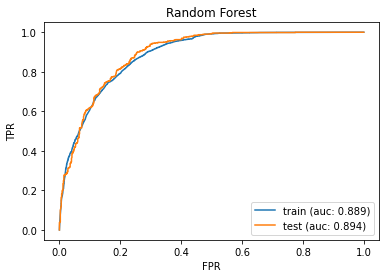

In [347]:
fpr_train, tpr_train, auc_train = roc(m_train, rf)
fpr_test, tpr_test, auc_test = roc(m_test, rf)

plt.plot(fpr_train, tpr_train, label='train (auc: %.3f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='test (auc: %.3f)' % auc_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest')
plt.legend();

In [361]:
# Optionally scale the data:
# split the data into train:test sets
# fit the transform on the training set
# transform both the training and test sets then recombine
scale_data = True

if scale_data:
    # gather combined training data for both datasets
    m_train, m_test, g_train, g_test = split_data(fm_mimic, fm_gicu, seed=seed)

    train_combined = m_train.append(g_train)
    test_combined = m_test.append(g_test)

    train_combined_feats = train_combined[features]

    # set up scaler, using all training data
    scaler = StandardScaler()
    scaler.fit(train_combined_feats)

    # Then apply the scaler to the original fm_mimic and fm_gicu, adding back in unscaled cols and save updated copies
    fm_mimic_standardscale_cols = pd.DataFrame(scaler.transform(fm_mimic[features]), columns = features)
    fm_gicu_standardscale_cols = pd.DataFrame(scaler.transform(fm_gicu[features]), columns = features)

    # Add back in other three columns 
    not_scaled = ['ICUSTAY_ID','cohort','outcome']

    not_scaled_fm_mimic = fm_mimic[not_scaled]
    not_scaled_fm_gicu = fm_gicu[not_scaled]

    fm_mimic_standardscale = pd.concat([not_scaled_fm_mimic, fm_mimic_standardscale_cols], axis=1)
    fm_gicu_standardscale = pd.concat([not_scaled_fm_gicu, fm_gicu_standardscale_cols], axis=1)

    # Now save:
    # scaled MIMIC and GICU datasets
    fm_mimic_standardscale.to_csv('fms/fm_mimic_imputed_extended_standardscale.csv', index=False)
    fm_gicu_standardscale.to_csv('fms/fm_gicu_imputed_extended_standardscale.csv', index=False)

    # save scaler function
    joblib.dump(scaler, 'standard_scaler.save')

    new_scaler = joblib.load('standard_scaler.save')

    reversed = pd.DataFrame(new_scaler.inverse_transform(fm_mimic_standardscale_cols), columns = features)

    print(reversed.head(2))




Using 0.8941 of MIMIC as training data
giving test sets gicu_test:1403 and mimic_test: 1403
     airway      fio2  spo2_min      hco3  resp_min  resp_max    bp_min  \
0 -0.569427  1.313961 -0.310969  0.063247 -0.703850 -1.170127  2.003506   
1 -0.569427  0.575756  1.111420  1.112160  0.588508 -0.009624  0.891544   

     hr_min    hr_max      pain  ...  temp_max  haemoglobin         k  \
0  0.304917 -0.227046  1.940477  ...  0.748216    -0.300501  0.824259   
1 -0.532657 -0.861744 -0.604484  ...  0.590078    -0.421960 -0.813367   

         na  creatinine       bun       bmi       los       age       sex  
0 -0.710476   -0.443744 -0.765125  0.022914 -0.678402 -0.148308  1.088614  
1  0.121503   -0.575071 -0.572680 -0.038786  0.666224 -0.350284  1.088614  

[2 rows x 22 columns]


In [372]:
test_combined[test_combined['ICUSTAY_ID'] == 2306]

,ICUSTAY_ID,cohort,outcome,airway,fio2,spo2_min,hco3,resp_min,resp_max,bp_min,...,temp_max,haemoglobin,k,na,creatinine,bun,bmi,los,age,sex
1861,2306,1,0,-0.569427,0.206653,-0.026491,-2.244362,0.103874,-1.170127,-1.471374,...,-2.019549,-0.355158,-0.631409,0.745488,2.445444,6.210988,-0.079291,0.553477,0.356634,-0.918599
977,2306,1,1,-0.569427,0.723397,-0.595447,0.210095,-0.057671,-0.672769,-1.564037,...,-0.374690,3.227877,-0.085533,-0.918471,-0.376120,-0.639963,-0.056806,-0.725659,-0.188703,-0.918599


In [374]:
mum = test_combined['ICUSTAY_ID'].value_counts()
mum.value_counts()

1    2720
2      43
Name: ICUSTAY_ID, dtype: int64